## Installing Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
# Create dataframe
df2018flights = pd.read_csv("./Datasets1/2018.csv")

# Remove op_carrier_fl_num, crs_dep_time, dep_time, wheels_off, wheels_on, cancelled, cancellation_co..., diverted, actual_elapsed_..., air_time, unnamed:27
df2018flights = df2018flights.drop(["OP_CARRIER_FL_NUM", "CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF", "WHEELS_ON", "CANCELLED", "CANCELLATION_CODE", "DIVERTED", "ACTUAL_ELAPSED_TIME", "AIR_TIME", "Unnamed: 27", "ARR_TIME"], axis= 1)

# Create month column
df2018flights["Month"] = pd.DatetimeIndex(df2018flights["FL_DATE"]).month

# Remove date column
df2018flights = df2018flights.drop(["FL_DATE"], axis= 1)

# Add labeled column
df2018flights["Label"] = np.where((df2018flights["ARR_DELAY"] > 0) & (df2018flights["ARR_DELAY"] <= 15), 1, 0)

# Remove column use to make label
df2018flights = df2018flights.drop(["ARR_DELAY"], axis= 1)

# Airlines to do not fall in hub and spoke or point to point
notRelId = ['9E', 'EV', 'MQ', 'OH', 'OO', 'YV', 'YX']

# Removing from dataframe
mask = ~df2018flights['OP_CARRIER'].isin(notRelId)

# New dataframe without notRel
df2018flights = df2018flights[mask]

# Dummy encode carrier, destination, and origin columns
df2018flights = pd.get_dummies(df2018flights, columns= ["OP_CARRIER", "ORIGIN", "DEST"])

df2018flights.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,...,DEST_TUL,DEST_TUS,DEST_TVC,DEST_TYS,DEST_USA,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YNG
0,-5.0,15.0,10.0,1745,268.0,1605.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,-8.0,11.0,7.0,1254,99.0,414.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,-5.0,15.0,5.0,1649,134.0,846.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,6.0,19.0,6.0,1756,190.0,1120.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,20.0,13.0,10.0,922,112.0,723.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Preparing and creating test train split
X = df2018flights.drop(["Label"], axis= 1)
y = df2018flights["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

## Catboost w/o Probabilities
This section demonstrates the accuracy at which the model can predict a flight being delayed when given binary (delayed or not) values

** Need to do some tuning on the model still **

Confusion matrix:
[[838845 172505]
 [ 32615 177239]]


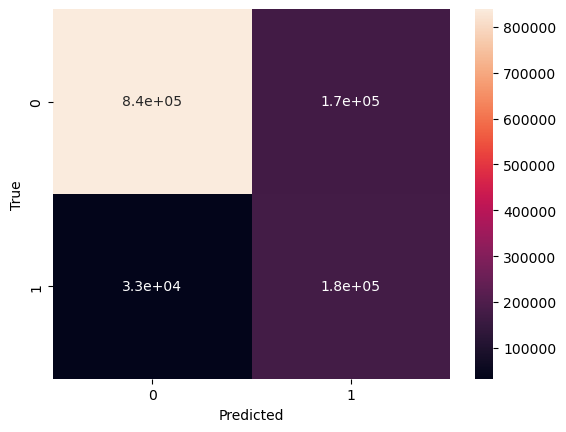

Accuracy: 0.8320346150192761
Precision: 0.50676780731049
Recall: 0.8445824239709512
F1 Score: 0.6334511560084203


In [4]:
## 😸boost ##

# Calculate balance of class weights
import sklearn
weights = sklearn.utils.class_weight.compute_class_weight(class_weight= 'balanced', classes= np.unique(y), y= y)

cb = CatBoostClassifier(iterations=100, random_seed=0, logging_level='Silent', class_weights= weights)
cb.fit(X_train, y_train)

# predict on test set
y_pred = cb.predict(X_test)

# evaluate model performance
conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion matrix:")
print(conf_mat)
sns.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [5]:
# Top predictors of flight being late
importance = cb.get_feature_importance()
cols = X.columns
indices = np.argsort(importance)[::-1]
print("Top Predictors of Upgrade:")
for i in range(X.shape[1]):
    print(f"{cols[indices[i]]}: {importance[indices[i]]}")

Top Predictors of Upgrade:
NAS_DELAY: 21.106003692730802
DEP_DELAY: 20.123198220938
CARRIER_DELAY: 16.084601765283708
LATE_AIRCRAFT_DELAY: 13.344851079124407
TAXI_OUT: 8.196931818672134
TAXI_IN: 6.126171410713459
CRS_ELAPSED_TIME: 4.30939191948739
DISTANCE: 2.673641706480965
SECURITY_DELAY: 2.2480825633166712
WEATHER_DELAY: 1.2916204928760304
Month: 0.7788928472992277
OP_CARRIER_DL: 0.40341655261515225
OP_CARRIER_WN: 0.21828147745379778
CRS_ARR_TIME: 0.19610211837434874
ORIGIN_JFK: 0.16820424769202977
ORIGIN_LGA: 0.16101672362264835
DEST_LAX: 0.15403201544912806
OP_CARRIER_HA: 0.13766839631543704
OP_CARRIER_AA: 0.13254740267706613
OP_CARRIER_AS: 0.1210450254462199
DEST_ORD: 0.11483935490501983
OP_CARRIER_UA: 0.10936317344945026
ORIGIN_SFO: 0.09556214817333418
ORIGIN_LAX: 0.09341863716447851
ORIGIN_SEA: 0.07845942436645309
OP_CARRIER_G4: 0.07425490284359419
ORIGIN_ATL: 0.07411065168267375
DEST_ATL: 0.06628126745894353
DEST_DFW: 0.06449712221902612
DEST_IAH: 0.05623186860289906
OP_CARRIE

<strong>Top predictors of a flight being delayed:</strong>
1. Air System Delay
2. Departure Delay
3. Carrier Delay
4. Late Aircraft Delay
5. Taxi Out
6. Taxi In
7. Estimated Arrival Time
8. Distance
9. Security Delay
10. Weather Delay

## Catboost with Probabilities
This section gathers the probability at which a flight will be delayed rather than giving it a binary value

** Using the same model as above **

In [6]:
## 😸boost w/o Probabilities##

# Calculate balance of class weights
import sklearn
weights = sklearn.utils.class_weight.compute_class_weight(class_weight= 'balanced', classes= np.unique(y), y= y)

cb = CatBoostClassifier(iterations=100, random_seed=0, logging_level='Silent', class_weights= weights)
cb.fit(X_train, y_train)

# predict probabilities on test set
y_predProba = cb.predict_proba(X_test)[::,1]

print(y_predProba)

[1.01670903e-01 3.16803953e-01 3.96618705e-01 ... 8.09153618e-01
 1.23052406e-02 2.28665553e-05]


## Developing New Flight Dataframe w/ Carrier, Origin, Destination, and ProbabilityDelayed

In [7]:
dfXtest = pd.DataFrame(X_test)
dfXtest.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,...,DEST_TUL,DEST_TUS,DEST_TVC,DEST_TYS,DEST_USA,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YNG
3585968,-6.0,11.0,8.0,858,118.0,694.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5311048,-3.0,17.0,5.0,2233,108.0,631.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2280862,-1.0,24.0,7.0,1040,154.0,802.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
812642,35.0,9.0,6.0,2220,210.0,1504.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2119058,-2.0,18.0,4.0,2008,293.0,1931.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Function to pull the locations (origin and destination) from X_test
def pullLocation(df, locType):
    newDict = {}

    df = df.filter(regex= locType).head(250000)

    for index, row in df.iterrows():
        for col in df.columns:
            if row[col] == 1:
                newDict[index] = col.split('_')[1]

    return newDict

# Function to pull the carrier from X_test
def pullCarrier(df):
    newDict = {}

    df = df.filter(regex= 'OP_CARRIER').head(250000)

    for index, row in df.iterrows():
        for col in df.columns:
            if row[col] == 1:
                newDict[index] = col.split('_')[2]

    return newDict

In [9]:
# Creating dataframes with origin location and destination location
dfOrigin = pd.DataFrame(pullLocation(dfXtest, 'ORIGIN').values(), index= pullLocation(dfXtest, 'ORIGIN').keys(), columns= ['Origin'])
dfDest = pd.DataFrame(pullLocation(dfXtest, 'DEST').values(), index= pullLocation(dfXtest, 'DEST').keys(), columns= ['Destination'])

# Creating dataframes with carrier
dfCarrier = pd.DataFrame(pullCarrier(dfXtest).values(), index= pullCarrier(dfXtest).keys(), columns= ["Carrier"])

In [10]:
# Creating dictionary with index as key and probabilities as values
probDict = {val: y_predProba[index] for index, val in enumerate(dfXtest.head(250000).index)}

# Creating dataframe for probabilities
dfProbs = pd.DataFrame(probDict.values(), index= probDict.keys(), columns= ["ProbabilityDelayed"])

In [11]:
# Merging all of these dataframes into one
dfModel = pd.concat([dfCarrier, dfOrigin, dfDest, dfProbs], axis= 1)

In [12]:
dfModel

,Carrier,Origin,Destination,ProbabilityDelayed
3585968,DL,CID,ATL,0.101671
5311048,AA,DFW,BNA,0.316804
2280862,UA,ORD,DFW,0.396619
812642,WN,AUS,EWR,0.000117
2119058,DL,MCO,SLC,0.363708
...,...,...,...,...
5480225,WN,SMF,SNA,0.106592
5695307,AA,ORD,PHX,0.225880
4977957,DL,MSN,MSP,0.000269
927368,WN,TPA,MDW,0.851564


## Performing Aggregations on Flight Routes

In [13]:
dfModel.groupby(['Carrier', 'Origin', 'Destination'])['ProbabilityDelayed'].agg(['count', 'mean'])

count      mean
Carrier Origin Destination                 
AA      ABQ    DFW            104  0.264568
               ORD             28  0.297615
               PHX              6  0.035165
        ALB    CLT             50  0.226553
        ANC    DFW              8  0.171482
...                           ...       ...
WN      TUS    LAX             59  0.314351
               MDW             15  0.310272
               OAK              1  0.045205
               SAN             32  0.210043
               SJC              1  0.941328

[6777 rows x 2 columns]

In [14]:
flightPreds = dfModel.groupby(['Carrier', 'Origin', 'Destination'])['ProbabilityDelayed'].agg(['count', 'mean']).reset_index()
flightPreds = flightPreds.rename(columns= {'count': 'NumFlights', 'mean': 'AvgProbDelayed'})
flightPreds

,Carrier,Origin,Destination,NumFlights,AvgProbDelayed
0,AA,ABQ,DFW,104,0.264568
1,AA,ABQ,ORD,28,0.297615
2,AA,ABQ,PHX,6,0.035165
3,AA,ALB,CLT,50,0.226553
4,AA,ANC,DFW,8,0.171482
...,...,...,...,...,...
6772,WN,TUS,LAX,59,0.314351
6773,WN,TUS,MDW,15,0.310272
6774,WN,TUS,OAK,1,0.045205
6775,WN,TUS,SAN,32,0.210043


In [15]:
# Changing carrier identifiers to names
carrierNamesDict = {'AA': 'American Airlines Inc.', 'AS': 'Alaksa Airlines Inc.', 'B6': 'JetBlue Airways', 'DL': 'Delta Air Lines Inc.', 'F9': 'Frontier Airlines Inc.', 'G4': 'Allegiant Air', 'HA': 'Hawaiian Airlines Inc.', 'NK': 'Spirit Air Lines', 'UA': 'United Air Lines Inc.', 'VX': 'Virgin America', 'WN': 'Southwest Airlines Co.'}
flightPreds['Carrier'] = flightPreds['Carrier'].replace(carrierNamesDict)
flightPreds

,Carrier,Origin,Destination,NumFlights,AvgProbDelayed
0,American Airlines Inc.,ABQ,DFW,104,0.264568
1,American Airlines Inc.,ABQ,ORD,28,0.297615
2,American Airlines Inc.,ABQ,PHX,6,0.035165
3,American Airlines Inc.,ALB,CLT,50,0.226553
4,American Airlines Inc.,ANC,DFW,8,0.171482
...,...,...,...,...,...
6772,Southwest Airlines Co.,TUS,LAX,59,0.314351
6773,Southwest Airlines Co.,TUS,MDW,15,0.310272
6774,Southwest Airlines Co.,TUS,OAK,1,0.045205
6775,Southwest Airlines Co.,TUS,SAN,32,0.210043


In [16]:
# Sorting the dataframe
flightPreds.sort_values(by= ['AvgProbDelayed'], ascending= False)

,Carrier,Origin,Destination,NumFlights,AvgProbDelayed
3843,Allegiant Air,SFB,ICT,1,9.891709e-01
3302,Allegiant Air,CKB,MYR,1,9.854157e-01
6334,Southwest Airlines Co.,OMA,TPA,1,9.851557e-01
5050,United Air Lines Inc.,ORD,SYR,1,9.835370e-01
610,American Airlines Inc.,PHX,IAH,1,9.833568e-01
...,...,...,...,...,...
2947,Frontier Airlines Inc.,PHL,IND,1,4.867242e-09
3872,Allegiant Air,SFB,SHV,1,3.262402e-09
3595,Allegiant Air,MTJ,LAX,1,8.429298e-10
2699,Frontier Airlines Inc.,IND,TPA,1,8.071105e-10


In [26]:
# Export to csv
flightPreds.to_csv('FlightPreds - Within15Late.csv')

## Performing Aggregations on Carriers & Op. Models

### Carriers

In [18]:
carrierPreds = dfModel.groupby(['Carrier'])['ProbabilityDelayed'].agg(['count', 'mean']).reset_index()
carrierPreds = carrierPreds.rename(columns= {'count': 'NumFlights', 'mean': 'AvgProbDelayed'})
carrierPreds

,Carrier,NumFlights,AvgProbDelayed
0,AA,47028,0.340252
1,AS,12508,0.376050
2,B6,15573,0.293682
3,DL,48633,0.287597
4,F9,6140,0.303454
5,G4,4904,0.326184
6,HA,4320,0.391637
7,NK,8950,0.310360
8,UA,31590,0.315796
9,VX,882,0.324392


In [19]:
# Changing carrier identifiers to names
carrierNamesDict = {'AA': 'American Airlines Inc.', 'AS': 'Alaksa Airlines Inc.', 'B6': 'JetBlue Airways', 'DL': 'Delta Air Lines Inc.', 'F9': 'Frontier Airlines Inc.', 'G4': 'Allegiant Air', 'HA': 'Hawaiian Airlines Inc.', 'NK': 'Spirit Air Lines', 'UA': 'United Air Lines Inc.', 'VX': 'Virgin America', 'WN': 'Southwest Airlines Co.'}
carrierPreds['Carrier'] = carrierPreds['Carrier'].replace(carrierNamesDict)
carrierPreds

,Carrier,NumFlights,AvgProbDelayed
0,American Airlines Inc.,47028,0.340252
1,Alaksa Airlines Inc.,12508,0.376050
2,JetBlue Airways,15573,0.293682
3,Delta Air Lines Inc.,48633,0.287597
4,Frontier Airlines Inc.,6140,0.303454
5,Allegiant Air,4904,0.326184
6,Hawaiian Airlines Inc.,4320,0.391637
7,Spirit Air Lines,8950,0.310360
8,United Air Lines Inc.,31590,0.315796
9,Virgin America,882,0.324392


In [20]:
# Sorting the dataframe
carrierPreds.sort_values(by= ['AvgProbDelayed'], ascending= False)

,Carrier,NumFlights,AvgProbDelayed
6,Hawaiian Airlines Inc.,4320,0.391637
1,Alaksa Airlines Inc.,12508,0.376050
10,Southwest Airlines Co.,69472,0.342406
0,American Airlines Inc.,47028,0.340252
5,Allegiant Air,4904,0.326184
9,Virgin America,882,0.324392
8,United Air Lines Inc.,31590,0.315796
7,Spirit Air Lines,8950,0.310360
4,Frontier Airlines Inc.,6140,0.303454
2,JetBlue Airways,15573,0.293682


In [27]:
# Export to csv
carrierPreds.to_csv('CarrierPreds - Within15Late.csv')

### Operation Models

In [22]:
# Declaring hub and spoke or point to point
opModelDict = {'American Airlines Inc.': 'HubSpoke', 'Alaksa Airlines Inc.': 'PointPoint', 'JetBlue Airways': 'PointPoint', 'Delta Air Lines Inc.': 'HubSpoke', 'Frontier Airlines Inc.': 'PointPoint', 'Allegiant Air': 'PointPoint', 'Hawaiian Airlines Inc.': 'PointPoint', 'Spirit Air Lines': 'PointPoint', 'United Air Lines Inc.': 'HubSpoke', 'Virgin America': 'PointPoint', 'Southwest Airlines Co.': 'PointPoint'}

dfOpModel = dfModel.copy()
dfOpModel['Carrier'] = dfOpModel['Carrier'].replace(carrierNamesDict)
dfOpModel['OpModel'] = dfOpModel['Carrier'].replace(opModelDict)
dfOpModel

,Carrier,Origin,Destination,ProbabilityDelayed,OpModel
3585968,Delta Air Lines Inc.,CID,ATL,0.101671,HubSpoke
5311048,American Airlines Inc.,DFW,BNA,0.316804,HubSpoke
2280862,United Air Lines Inc.,ORD,DFW,0.396619,HubSpoke
812642,Southwest Airlines Co.,AUS,EWR,0.000117,PointPoint
2119058,Delta Air Lines Inc.,MCO,SLC,0.363708,HubSpoke
...,...,...,...,...,...
5480225,Southwest Airlines Co.,SMF,SNA,0.106592,PointPoint
5695307,American Airlines Inc.,ORD,PHX,0.225880,HubSpoke
4977957,Delta Air Lines Inc.,MSN,MSP,0.000269,HubSpoke
927368,Southwest Airlines Co.,TPA,MDW,0.851564,PointPoint


In [23]:
opModelPreds = dfOpModel.groupby(['OpModel'])['ProbabilityDelayed'].agg(['count', 'mean']).reset_index()
opModelPreds = opModelPreds.rename(columns= {'count': 'NumFlights', 'mean': 'AvgProbDelayed'})
opModelPreds

,OpModel,NumFlights,AvgProbDelayed
0,HubSpoke,127251,0.314057
1,PointPoint,122749,0.336323


In [24]:
# Sorting the dataframe
opModelPreds.sort_values(by= ['AvgProbDelayed'], ascending= False)

,OpModel,NumFlights,AvgProbDelayed
1,PointPoint,122749,0.336323
0,HubSpoke,127251,0.314057


In [28]:
# Export to csv
opModelPreds.to_csv('OpModelPreds - Within15Late.csv')